In [18]:
import link_bot_classifiers
from link_bot_data.classifier_dataset import ClassifierDataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import json
from moonshine.gpu_config import limit_gpu_mem
from link_bot_pycommon.get_scenario import get_scenario
import link_bot_classifiers
from link_bot_data.link_bot_dataset_utils import add_planned
from scipy import stats

plt.style.use("slides")
np.set_printoptions(suppress=True, linewidth=250)
limit_gpu_mem(1)

## Dataset

In [65]:
dataset_dirs = [pathlib.Path("classifier_data/rope_relaxed_mer/")]
classifier_dataset = ClassifierDataset(dataset_dirs)
tf_dataset = classifier_dataset.get_datasets(mode='train')

## Model

In [3]:
checkpoint = pathlib.Path("log_data/rope_rnn_lr=0.0001/May_12_12-09-06_7acb2e27c8")
model_hparams = json.load((checkpoint / 'hparams.json').open('r'))
model = link_bot_classifiers.get_model(model_hparams['model_class'])
scenario = get_scenario(classifier_dataset.hparams['scenario'])
net = model(hparams=model_hparams, batch_size=1, scenario=scenario)

In [116]:
all_mean_stdevs = []
all_labels = []
mean_stdevs_positive = []
mean_stdevs_negative = []
stdevs_positive_by_seq_len = {i:[] for i in range(5)}
stdevs_negative_by_seq_len = {i:[] for i in range(5)}
for i, example in enumerate(tf_dataset.take(10000)):
    last_valid_idx = int(example['last_valid_idx'].numpy().squeeze())
    stdevs = example[add_planned('stdev')].numpy().squeeze()
    valid_stdevs = stdevs[:last_valid_idx + 1]
    label = example['label'].numpy().squeeze()
    mean_stdev = np.mean(valid_stdevs)
    all_mean_stdevs.append(mean_stdev)
    all_labels.append(label)
    if label:
        mean_stdevs_negative.append(mean_stdev)
        for t in range(last_valid_idx):
            stdevs_positive_by_seq_len[last_valid_idx].append(valid_stdevs[t])
    else:
        mean_stdevs_positive.append(mean_stdev)
        for t in range(last_valid_idx):
            stdevs_negative_by_seq_len[last_valid_idx].append(valid_stdevs[t])

In [107]:
def fit_kernel(stdevs):
    kernel = stats.gaussian_kde(stdevs)
    stdev_samples = np.linspace(0, 1, 500)
    density = kernel(stdev_samples)
    return stdev_samples, density
    
    
def compare(stdevs_negative, stdevs_positive):
    stdev_samples, density_negative = fit_kernel(stdevs_negative)
    stdev_samples, density_positive = fit_kernel(stdevs_positive)
    
    plt.figure(figsize=(10,6))
    plot_every = 100
    plt.plot(stdev_samples, density_negative, label='negative examples', linewidth=1, c='k')
    plt.plot(stdev_samples, density_positive, label='positive examples', linewidth=1, c='m')
    plt.scatter(stdevs_negative[::plot_every], np.ones_like(stdevs_negative[::plot_every])*-0.1, c='k', alpha=0.01)
    plt.scatter(stdevs_positive[::plot_every], np.ones_like(stdevs_positive[::plot_every])*-0.2, c='m', alpha=0.01)
    plt.xlabel("mean stdev")
    plt.ylabel("density")
    plt.title("Correlation between\nmean stdev and label")
    plt.legend();

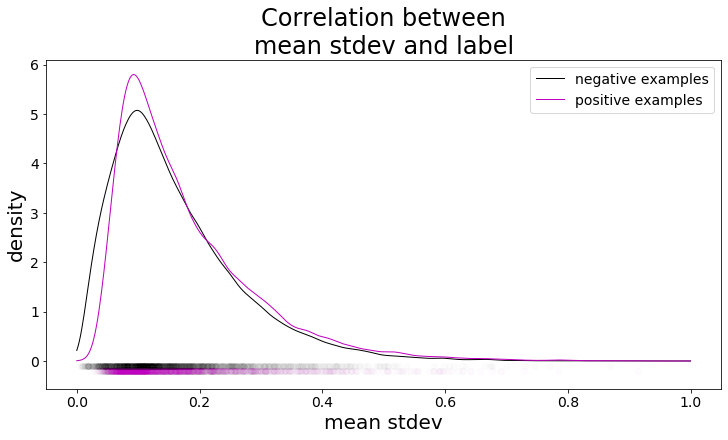

In [108]:
compare(mean_stdevs_negative, mean_stdevs_positive)
print(f"mean stdev for negative examples {np.mean(mean_stdevs_negative):.3f}")
print(f"mean stdev for positive examples {np.mean(mean_stdevs_positive):.3f}")

mean stdev at t=1 for negative examples 0.149
mean stdev at t=1 for positive examples 0.141


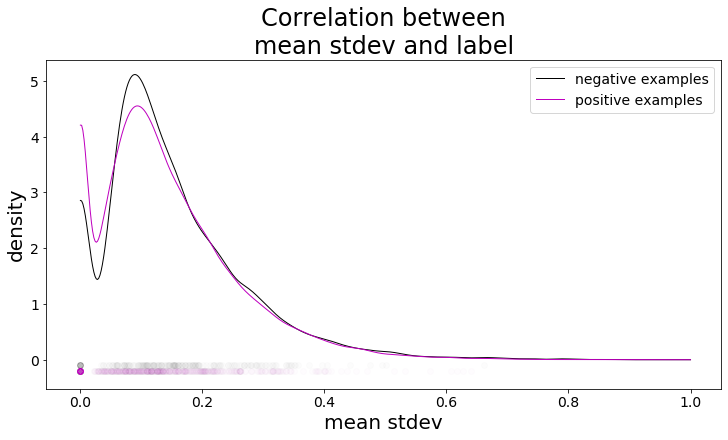

In [113]:
compare(stdevs_negative_by_seq_len[1], stdevs_positive_by_seq_len[1])
print(f"mean stdev at t=1 for negative examples {np.mean(stdevs_negative_by_seq_len[1]):.3f}")
print(f"mean stdev at t=1 for positive examples {np.mean(stdevs_positive_by_seq_len[1]):.3f}")

mean stdev at t=2 for negative examples 0.157
mean stdev at t=2 for positive examples 0.152


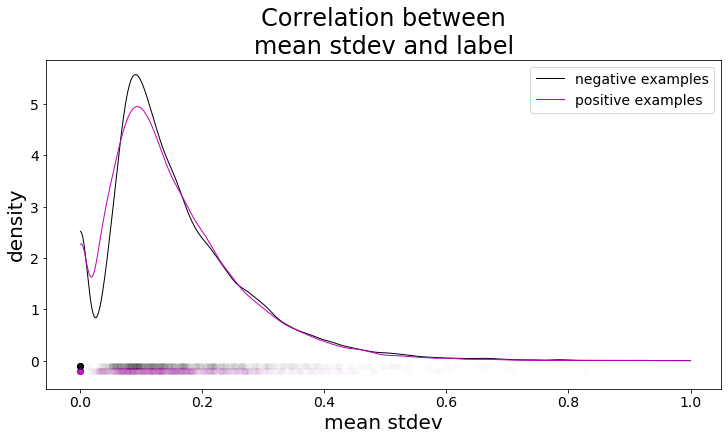

In [114]:
compare(stdevs_negative_by_seq_len[2], stdevs_positive_by_seq_len[2])
print(f"mean stdev at t=2 for negative examples {np.mean(stdevs_negative_by_seq_len[2]):.3f}")
print(f"mean stdev at t=2 for positive examples {np.mean(stdevs_positive_by_seq_len[2]):.3f}")

mean stdev at t=3 for negative examples 0.179
mean stdev at t=3 for positive examples 0.188


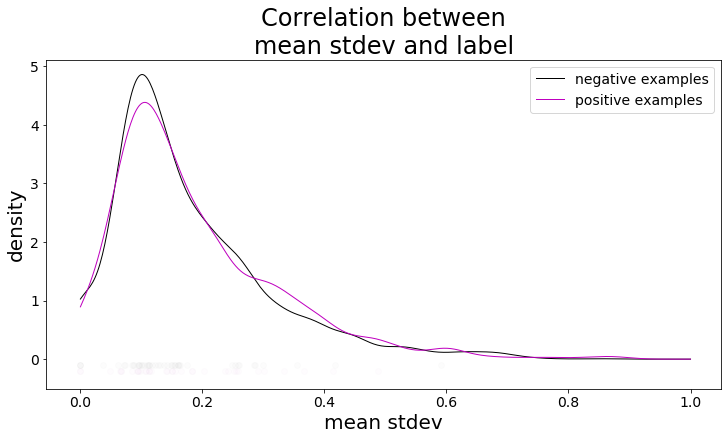

In [117]:
compare(stdevs_negative_by_seq_len[3], stdevs_positive_by_seq_len[3])
print(f"mean stdev at t=3 for negative examples {np.mean(stdevs_negative_by_seq_len[3]):.3f}")
print(f"mean stdev at t=3 for positive examples {np.mean(stdevs_positive_by_seq_len[3]):.3f}")

mean stdev at t=4 for negative examples 0.187
mean stdev at t=4 for positive examples 0.196


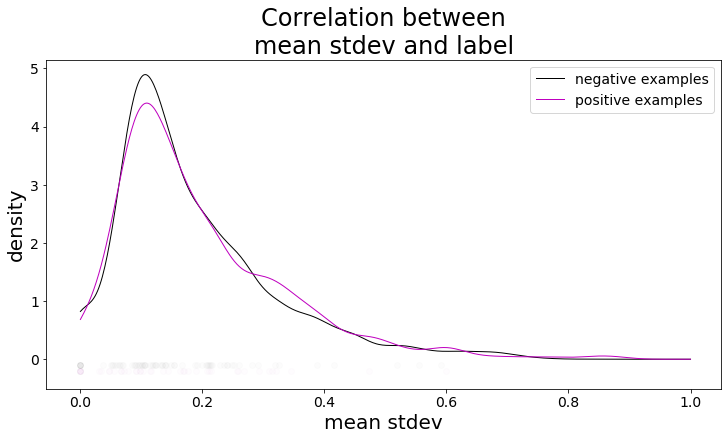

In [118]:
compare(stdevs_negative_by_seq_len[4], stdevs_positive_by_seq_len[4])
print(f"mean stdev at t=4 for negative examples {np.mean(stdevs_negative_by_seq_len[4]):.3f}")
print(f"mean stdev at t=4 for positive examples {np.mean(stdevs_positive_by_seq_len[4]):.3f}")